In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, maskoceans
import tables as tb
from rpn.domains.rotated_lat_lon import RotatedLatLon
from matplotlib.gridspec import GridSpec
import numpy as np

bmap_params = {'llcrnrlat': 39.004303137858841,
               'urcrnrlat': 62.443077596938053,
               'projection': 'rotpole',
               'llcrnrlon': -86.99883217016388,
               'urcrnrlon': -40.221671371989302,
               'lon_0': -73.350000000000009,
               'o_lat_p': 37.878708451507158,
               'resolution': 'l',
               'o_lon_p': 176.70918638372871}


In [2]:
path = "/home/huziy/skynet3_rech1/hdf_store/quebec_0.1_crcm5-hcd-rl-intfl_spinup_ITFS.hdf5"
lf_node_path = "/lake_fraction"

In [3]:
proj_params = {}
with tb.open_file(path) as h:
    lons, lats = h.get_node("/longitude")[:], h.get_node("/latitude")[:]
    data = h.get_node(lf_node_path)[:]
    
    for row in h.get_node("/rotpole"):
        proj_params[row["name"].decode()] = row["value"]
        
print(proj_params)

{'lon1': 292.0, 'lat1': 52.0, 'lat2': 0.0, 'lon2': 16.649999618530273}


In [4]:
rll = RotatedLatLon(**proj_params)

{}
292.0 52.0 16.649999618530273 0.0


In [5]:
bmp = rll.get_basemap_object_for_lons_lats(lons2d=lons, lats2d=lats, resolution="l")

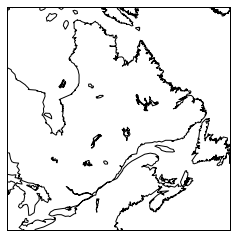

In [6]:
bmp.drawcoastlines()

In [7]:
xx, yy = bmp(lons, lats)

In [8]:
lons[lons > 180] -= 360
data = maskoceans(lons, lats, data, inlands=False)

In [9]:
def plot_ax_mean(xx, yy, to_plot, ax, axis_index=0, add_legend=False):
    
    #for all grid points
    z = np.zeros_like(to_plot)
    z[to_plot.mask] = 0
    z[~to_plot.mask] = to_plot[~to_plot.mask]
    
    xarr = z.mean(axis=axis_index) * 100
    xarr1 = to_plot.mean(axis=axis_index) * 100
    
    
    if axis_index == 0:
        yarr = xx[:, 0]
        yarr1 = xx[:, 0]
    else:
        yarr = yy[0, :]
        yarr1 = yy[0, :]
        
    
    
    if axis_index == 0:
        xarr, yarr = yarr, xarr
        xarr1, yarr1 = yarr1, xarr1
        
    ax.plot(xarr, yarr, "k", label="All")

    #land only
    ax.plot(xarr1, yarr1, "r--", label="Land")
    
    for tl in ax.xaxis.get_ticklabels():
        tl.set_visible(axis_index == 1)

    for tl in ax.yaxis.get_ticklabels():
        tl.set_visible(axis_index == 0)

        
    if add_legend:
        ax.legend(frameon=False)
    

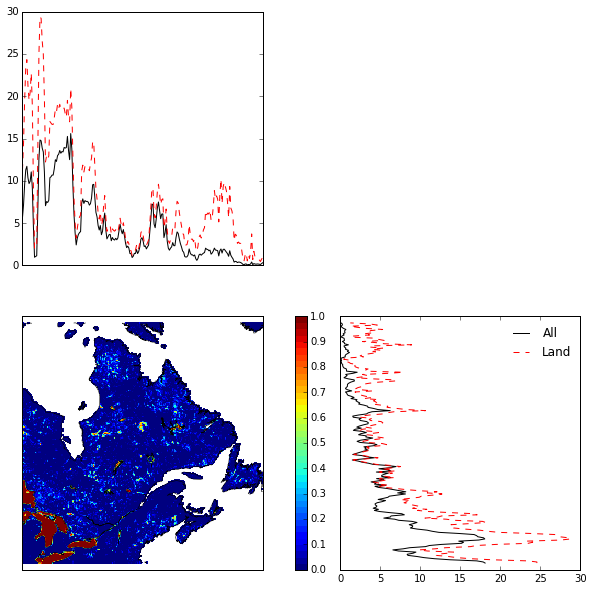

In [10]:
from matplotlib import cm

gs = GridSpec(2, 3, width_ratios=[1, 0.05, 1])

fig = plt.figure(figsize=(10, 10))
ax_field = fig.add_subplot(gs[1, 0])
ax_right = fig.add_subplot(gs[1,2], sharey=ax_field)
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_field)
cax = fig.add_subplot(gs[1, 1])

im = bmp.pcolormesh(xx, yy, data, vmin=0, vmax=1, ax=ax_field, cmap=cm.get_cmap("jet", 40))
plt.colorbar(im, cax=cax)
bmp.drawcoastlines(linewidth=0.6, ax=ax_field)

plot_ax_mean(xx, yy, data, ax_right, axis_index=1, add_legend=True)
plot_ax_mean(xx, yy, data, ax_top, axis_index=0, add_legend=False)


In [ ]:

from matplotlib import cm

gs = GridSpec(2, 3, width_ratios=[1, 0.05, 1])

fig = plt.figure(figsize=(10, 10))
ax_field = fig.add_subplot(gs[1, 0])
ax_right = fig.add_subplot(gs[1,2], sharey=ax_field)
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_field)
cax = fig.add_subplot(gs[1, 1])

im = bmp.pcolormesh(xx, yy, data, vmin=0, vmax=1, ax=ax_field, cmap=cm.get_cmap("jet", 40))
plt.colorbar(im, cax=cax)
bmp.drawcoastlines(linewidth=0.6, ax=ax_field)

plot_ax_mean(xx, yy, data, ax_right, axis_index=1, add_legend=True)
plot_ax_mean(xx, yy, data, ax_top, axis_index=0, add_legend=False)


rpole_crs = ccrs.RotatedPole(pole_longitude=bmap_params["lon_0"] + 180, 
                             pole_latitude=bmap_params["o_lat_p"])

ax = plt.axes(projection=rpole_crs)
ax.coastlines(resolution='50m')

ax.gridlines()
xll, yll = rpole_crs.transform_point(bmap_params["llcrnrlon"], bmap_params["llcrnrlat"], ccrs.Geodetic())
xur, yur = rpole_crs.transform_point(bmap_params["urcrnrlon"], bmap_params["urcrnrlat"], ccrs.Geodetic())
ax.set_extent([xll, xur, yll, yur], crs=rpole_crs)



